In [79]:
!pip install -r "../requirements.txt"

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/6.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/6.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/6.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/6.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/6.8 MB ? eta -:--:--
   --- ------------------------------------ 0.5/6.8 MB 540.5 kB/s eta 0:00:12
   --- ------------------------------------ 0.5/6.8 MB 540.5 kB/s eta 0:00:12
   ---- ----------------------------------- 0.8/6.8 MB 516.0 kB/s eta 0:00:12
   ---- ----------------------------------- 0.8/6.8 MB 516.0 kB/s eta 0:00:12
   ---- ----------------------------------- 0.8/6.8 MB 516.0 kB/s eta 0:00:12
   ------ --------------------------------- 1.0/6.8 MB 529.6 kB/s eta 0:00:11
   ------- -------------------------------- 1.3/6.8 MB 563.8 kB/s eta 0:00:10
   ------- --------------------

In [1]:
import os

documents_dir = "documents/"
target_folders = ["Condotril", "Duobiotic", "Neurofil"]  # nomes dos produtos
documents = {folder: "" for folder in target_folders}  # Inicializa um dicionário para cada produto

for folder in target_folders:
    folder_path = os.path.join(documents_dir, folder)
    
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        for doc_name in os.listdir(folder_path):
            if doc_name.endswith(".txt"):
                print(f"txt encontrado ({doc_name})!")
                file_path = os.path.join(folder_path, doc_name)
                with open(file_path, "r", encoding="utf-8") as doc:
                    content = doc.read()
                    documents[folder] += content + "\n"

txt encontrado (Condotril_bula.txt)!
txt encontrado (Duobiotic_bula.txt)!
txt encontrado (Neurofil_bula.txt)!


In [2]:
documents

{'Condotril': '=D MYPharmã\n\nCONDOTRIL\n\nO QUE É CONDOTRIL?\n\nCONDOTRIL é um suplemento alimentar que contém Sulfato de Glucosamina, Sulfato de Condroitina,\nMSM e outros compostos como a Vitamina C e Manganês. A Vitamina C contribui para a normal for-\nmação de colagénio para o funcionamento normal dos ossos e das cartilagens. O Manganês con-\ntribui para a manutenção de ossos normais e a normal formação de tecidos conjuntivos.\n\nOs suplementos alimentares são géneros alimentícios que se destinam a complementar e/ou a\nsuplementar o regime alimentar normal não devendo ser utilizados como substitutos de um regime\nalimentar variado. Constituem fontes concentradas de determinadas substâncias nutrientes ou\noutras, com efeito nutricional ou fisiológico. É importante um regime alimentar equilibrado e um\nmodo de vida saudável.\n\nIngredientes: Agente de volume: Maltodextrina; Sulfato de glucosamina (marinho); Sulfato\nde condroitina; Agente de volume: Fosfato dicálcico; Cartilagem de 

# Question Generator

In [3]:
from langchain_ollama.llms import OllamaLLM

model = OllamaLLM(model="llama3.1:8b")

# original questions
questions = ["Quais sao os ingredientes do Condotril?",
"Quais sao os ingredientes do Duobiotic?",
"Quais sao os ingredientes do Neurofil?",
"Quais sao os efeitos do Condotril?",
"Quais sao os efeitos do Duobiotic?",
"Quais sao os efeitos do Neurofil?",
"Qual e o processo de toma do Condotril?",
"Qual e o processo de toma do Duobiotic?",
"Qual e o processo de toma do Neurofil?",
"Quais sao as condicoes de armazenamento do Condotril?",
"Quais sao as condicoes de armazenamento do Duobiotic?",
"Quais sao as condicoes de armazenamento do Neurofil?",
"Em que casos nao se pode tomar Condotril?",
"Em que casos nao se pode tomar Duobiotic?",
"Em que casos nao se pode tomar Neurofil?",
"Quantas doses tem a embalagem do Condotril?",
"Quantas doses tem a embalagem do Duobiotic?",
"Quantas doses tem a embalagem do Neurofil?"]

### Variants

In [ ]:
#!ollama pull llama3.1:8b

In [5]:
def generate_variants(model, questions, n=4):
    variants = {}
    for question in questions:
        system_prompt =  """Your role is to rephrase this question in different ways, keeping the meaning: {question}.
        Never give a question in english, only in portuguese.""".format(question=question)

        response = model.generate(prompts=[system_prompt], num_return_sequences=n)
        variants[question] = [variant for variant in response.generations]
    return variants

In [97]:
question_variants = generate_variants(model, questions, n=4)

In [98]:
for original, variants in question_variants.items():
    print(f"Original: {original}")
    for i, variant in enumerate(variants, 1):
        print(f"Variant {i}: {variant}")
    print()

Original: Quais sao os ingredientes do Condotril?
Variant 1: [GenerationChunk(text='Aqui estão algumas reformulações da pergunta:\n\n* Quais são as componentes fundamentais do Condotril?\n* O que compõe o Condotril?\n* Qual é a composição do Condotril?\n* Em que se baseia a fórmula do Condotril?\n* Quais são os principais ingredientes utilizados no fabrico do Condotril?', generation_info={'model': 'llama3.1:8b', 'created_at': '2024-11-25T16:39:11.7787811Z', 'response': '', 'done': True, 'done_reason': 'stop', 'context': [128006, 882, 128007, 271, 7927, 3560, 374, 311, 312, 28810, 420, 3488, 304, 2204, 5627, 11, 10494, 279, 7438, 25, 3489, 2852, 104372, 2709, 25795, 288, 656, 1221, 16510, 31660, 30, 627, 286, 15037, 3041, 264, 3488, 304, 30063, 11, 1193, 304, 2700, 773, 36554, 13, 128009, 128006, 78191, 128007, 271, 32, 47391, 57554, 93112, 15180, 5724, 15607, 3067, 824, 61010, 1473, 9, 3489, 2852, 30710, 439, 3777, 288, 12762, 2852, 656, 1221, 16510, 31660, 5380, 9, 507, 1744, 1391, 11

### Normalizar as variantes (remover acentos e pontuação)

In [4]:
import re
import unicodedata

def remove_acentos(text):
    nfkd_form = unicodedata.normalize('NFKD', text)
    return ''.join([c for c in nfkd_form if not unicodedata.combining(c)])

def remove_pontuation(text):
        return re.sub(r"[^\w\s]", "", text) # remove todos os caracteres exceto letras e numeros

In [ ]:
var = {}
var_normalized = {}

for original, variants in question_variants.items():
    QV = []
    #return re.sub(r"[^\w\s\!\?\.\']", "", text)
    for variant in variants:
        responses = re.split(r'[\n\*|\n,]', variant[0].text)
        responses = [resp.strip() 
                     for resp in responses[1:] if resp.strip()]
        QV.extend(responses)
    var[original] = QV

for original, variants in var.items():
    QV = []
  
    original = remove_acentos(remove_pontuation(original))
    
    for variant in variants:
        variant = remove_pontuation(variant) 
        variant = remove_acentos(variant)
        
        QV.append(variant)
    
    var_normalized[original] = QV

    print(f"Original: {original}")
    print("Variantes:")
    for variant in var_normalized[original]:
        print("- ", variant)
    print()

NameError: name 'question_variants' is not defined

### Guardar variantes em .csv

In [9]:
import pandas as pd

variants_df = pd.DataFrame(list(var_normalized.items()), columns=["original", "variants"])
max_variants = max(variants_df["variants"].apply(len))
variants_expanded = pd.DataFrame(variants_df["variants"].tolist(), columns=[f"variant_{i+1}" for i in range(max_variants)])
variants_df = pd.concat([variants_df["original"], variants_expanded], axis=1)

NameError: name 'var_normalized' is not defined

In [ ]:
variants_df

,original,variant_1,variant_2,variant_3,variant_4,variant_5,variant_6,variant_7,variant_8,variant_9,variant_10
0,Quais sao os ingredientes do Condotril,Quais sao as componentes fundamentais do Condo...,O que compoe o Condotril,Qual e a composicao do Condotril,Em que se baseia a formula do Condotril,Quais sao os principais ingredientes utilizado...,None,None,None,None,None
1,Quais sao os ingredientes do Duobiotic,Qual e a composicao quimica do Duobiotic,O que contem o Duobiotic como ingrediente ativo,Sao quais os componentes do Duobiotic,Quais sao as substancias presentes no Duobiotic,Qual e a formula do Duobiotic,None,None,None,None,None
2,Quais sao os ingredientes do Neurofil,Qual e a composicao do Neurofil,Quais sao as substancias que compoem o Neurofil,O que esta presente no composto conhecido como...,Que ingredientes ou componentes fazem parte da...,Quais os constituintes quimicos do Neurofil,None,None,None,None,None
3,Quais sao os efeitos do Condotril,O que acontece com as pessoas que utilizam o C...,Quais sao as consequencias de usar o Condotril,Como afeta o corpo humano o uso do Condotril,Quais sao os danos causados pelo Condotril,O que acontece com a saude quando se utiliza o...,None,None,None,None,None
4,Quais sao os efeitos do Duobiotic,Qual e o resultado de usar o Duobiotic,O que acontece quando se toma o Duobiotic,Quais sao as consequencias de consumir o Duobi...,Como afeta o organismo o uso do Duobiotic,Quais sao os efeitos colaterais ou secundarios...,Qual e a resposta do corpo ao Duobiotic,None,None,None,None
5,Quais sao os efeitos do Neurofil,1 Qual e o impacto do Neurofil no organismo,2 Como afeta o corpo humano o consumo de Neurofil,3 Quais sao as consequencias da ingestao de Ne...,4 O que acontece com o corpo quando se toma um...,5 Quais sao os efeitos secundarios do uso de p...,None,None,None,None,None
6,Qual e o processo de toma do Condotril,Como se desenvolveu o processo de construcao d...,Quais foram as etapas que levaram a criacao do...,O que aconteceu para que o Condotril fosse con...,Descreva como foi feito o processo de elaborac...,Quais sao os principais passos que compuseram ...,Como foi organizado e executado o projeto do C...,Qual foi o fluxo de trabalho usado para criar ...,None,None,None
7,Qual e o processo de toma do Duobiotic,Como funciona a tomada do Duobiotic,O que e necessario para tomar Duobiotic,Quais sao os passos para administrar Duobiotic,Qual e o procedimento para ingestao de Duobiotic,Como se toma corretamente o Duobiotic,None,None,None,None,None
8,Qual e o processo de toma do Neurofil,Como se adquire o Neurofil,O que e necessario para obter o Neurofil,Quais sao os passos para adquirir o Neurofil,Qual e a forma correta de obter o Neurofil,Quem pode tomar ou comprar um Neurofil,None,None,None,None,None
9,Quais sao as condicoes de armazenamento do Con...,1 Como devem ser armazenadas as pecas da Condo...,2 Quais sao os requisitos para o armazenamento...,3 O que e necessario saber sobre a conservacao...,4 Em que condicoes deve ser guardado o Condotril,5 Qual e a recomendacao para o armazenamento d...,6 Quais sao as normas para o armazenamento do ...,7 Como devemos proceder para armazenar o Condo...,8 Quais sao os criterios para o armazenamento ...,Essas perguntas mantem a mesma essencia da ori...,apenas com diferentes frases e estruturas


In [ ]:
variants_df.to_csv('variants.csv')

### Handle speling

In [5]:
from fuzzywuzzy import fuzz
from autocorrect import Speller
from spellchecker import SpellChecker
import re
import csv

def load_variants_from_csv(file_path):
    quest_variants = {}
    with open(file_path, mode='r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            original = row['original']  # A coluna principal com a pergunta original
            # Filtrar todas as variantes não vazias
            variants = [row[key] for key in row if key.startswith('variant_') and row[key].strip()]
            quest_variants[original] = variants  # Mapear original -> lista de variantes
    return quest_variants

# spell = Speller(lang='pt')
spell = SpellChecker(language='pt')

def normalize_text(text):
        return re.sub(r"[^\w\s']", "", text)


def choose_best_question_variant(user_question, quest_variants):
    best_score = 0
    best_match = None

    # print("original:", user_question)

    # user_question = spell(user_question) # CATARINA
    user_question = spell.correction(user_question) # MARTA
    print("spell.correction: ", user_question) # NAO FUNCIONA ############################################################

    user_question = normalize_text(user_question)
    # print("normalize_text: ", user_question)

    user_question = remove_acentos(remove_pontuation(user_question))
    # print("remove_acentos: ", user_question, "\n")
    
    user_question = user_question.lower()

    # Comparação com perguntas originais e variantes
    for original, variants in quest_variants.items():
        # Verifica a similaridade com a pergunta original
        score_with_original = fuzz.ratio(user_question, original.lower())
        if score_with_original > best_score:
            best_score = score_with_original
            best_match = original
            # Se a original for altamente semelhante, priorize-a
            if best_score >= 98:
                break

        # Verifica a similaridade com cada variante
        for variant in variants:
            score_with_variant = fuzz.ratio(user_question, variant.lower())
            if score_with_variant > best_score:
                best_score = score_with_variant
                best_match = original

    return best_match, best_score


C:\Users\marta\AppData\Roaming\Python\Python312\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [6]:
import re
from langchain.tools import BaseTool
from fuzzywuzzy import fuzz
import csv

class QuestionVariantSelector(BaseTool):
    name: str = "QuestionVariantSelector"
    description: str = "Seleciona a melhor variante de uma pergunta baseada em variantes carregadas de um CSV."
    file_path: str  # Caminho para o CSV com variantes

    def __init__(self, file_path):
        self.variants = self.load_variants_from_csv(file_path)

    def load_variants_from_csv(self, file_path: str) -> dict:
        """Carrega as variantes de perguntas de um arquivo CSV."""
        quest_variants = {}
        with open(file_path, mode='r', encoding='utf-8') as file:
            reader = csv.DictReader(file)
            for row in reader:
                original = row['original']
                variants = [row[key] for key in row if key.startswith('variant_') and row[key].strip()]
                quest_variants[original] = variants
        return quest_variants

    def choose_best_variant(self, user_question: str) -> tuple[str, int]:
        """Encontra a melhor variante para a pergunta do usuário."""
        best_match = user_question
        best_score = 0

        for original, variants in self.variants.items():
            for variant in variants:
                score = fuzz.ratio(user_question.lower(), variant.lower())
                if score > best_score:
                    best_score = score
                    best_match = original

        return best_match, best_score

    def _run(self, question: str) -> dict:
        """Processa a pergunta do usuário e retorna a melhor variante encontrada."""
        best_match, score = self.choose_best_variant(question)
        if score < 65:  # Limite mínimo para considerar uma variante
            best_match = question
        
        

        return {"question": best_match, "score": score}

Teste de uma pergunta com erros ortográficos e diferente das perguntas default

In [7]:
teste_com_erros = "quantós comprmídos d~evo tomâr de duobitiic?"
file_path = 'variants.csv'
result, score = choose_best_question_variant(teste_com_erros, load_variants_from_csv(file_path))
if score < 65:
    result = teste_com_erros
print(f"User question: {teste_com_erros}\nMelhor variante: {result}\nscore: {score}")

spell.correction:  quantós comprmídos d~evo tomâr de duobitiic?
User question: quantós comprmídos d~evo tomâr de duobitiic?
Melhor variante: Qual e o processo de toma do Duobiotic
score: 70


# Create Chunks

In [12]:
from langchain_text_splitters import CharacterTextSplitter

text_splitter = CharacterTextSplitter(
    separator="\n\n",
    chunk_size=1200, # o chunk_size tem que ser grande para termos o maximo de informaçao sobre um produto num vetor apenas
    chunk_overlap=200,
    length_function=len,
    is_separator_regex=False,
)

docs = []
for name, content in documents.items():
    # Adiciona o nome do medicamento no início do conteúdo antes de dividir
    full_content = f"Medicamento: {name}\n\n{content}"
    chunks = text_splitter.create_documents([full_content])
    
    # Adiciona o nome do medicamento diretamente ao conteúdo de cada chunk
    for chunk in chunks:
        chunk.metadata = {"medicamento": name}
        chunk.page_content = f"{name}\n\n{chunk.page_content}"
    
    docs.extend(chunks)

for _, (product, content) in enumerate(documents.items()):
    num_characters = len(content)
    print(f"Número de caracteres no documento '{product}': {num_characters}")

print("Número de documents: ", len(docs))

Número de caracteres no documento 'Condotril': 3161
Número de caracteres no documento 'Duobiotic': 3207
Número de caracteres no documento 'Neurofil': 2871
Número de documents:  10


In [13]:
docs

[Document(metadata={'medicamento': 'Condotril'}, page_content='Condotril\n\nMedicamento: Condotril\n\n=D MYPharmã\n\nCONDOTRIL\n\nO QUE É CONDOTRIL?\n\nCONDOTRIL é um suplemento alimentar que contém Sulfato de Glucosamina, Sulfato de Condroitina,\nMSM e outros compostos como a Vitamina C e Manganês. A Vitamina C contribui para a normal for-\nmação de colagénio para o funcionamento normal dos ossos e das cartilagens. O Manganês con-\ntribui para a manutenção de ossos normais e a normal formação de tecidos conjuntivos.\n\nOs suplementos alimentares são géneros alimentícios que se destinam a complementar e/ou a\nsuplementar o regime alimentar normal não devendo ser utilizados como substitutos de um regime\nalimentar variado. Constituem fontes concentradas de determinadas substâncias nutrientes ou\noutras, com efeito nutricional ou fisiológico. É importante um regime alimentar equilibrado e um\nmodo de vida saudável.'),
 Document(metadata={'medicamento': 'Condotril'}, page_content='Condotr

# Create VectorStore/Retriever

In [14]:
# ollama needs to be installed
# https://ollama.com/
# https://github.com/ollama/ollama/tree/main/docs
from langchain_ollama import OllamaEmbeddings
from langchain_community.vectorstores import FAISS

embedding_model = OllamaEmbeddings(
    # model="nomic-embed-text",
    model="llama3.1:8b",
)

vectorstore = FAISS.from_documents(docs, embedding=embedding_model)
vectorstore.save_local(folder_path = 'vectorstore') # save the vectorstore locally

In [16]:
retriever = FAISS.load_local(
    folder_path='vectorstore',
    embeddings=embedding_model,
    allow_dangerous_deserialization=True
    ).as_retriever(search_kwargs={"k" : 5})

# Load Document

In [8]:
question = "Quais são os items do Condotril"
result, score = choose_best_question_variant(question, load_variants_from_csv(file_path))
if score < 65:
    result = question
print(f"User question: {question}\nMelhor variante: {result}\nscore: {score}")
retriever.invoke(result)

spell.correction:  Quais são os items do Condotril
User question: Quais são os items do Condotril
Melhor variante: Quais sao os efeitos do Condotril
score: 91


NameError: name 'retriever' is not defined

In [9]:
import re
from langchain.tools import BaseTool

class ArticleInformation(BaseTool):
    name: str = "ArticleInformation"
    description: str = "This tool is used to answer questions about MyPharma food suplements. The input is the original user question"
        
    def _run(self, question):
        retrieved_documents = retriever.invoke(question)  # Obtém documentos
        medicamentos = self._extract_medicamento(question)  # Extrai os nomes dos medicamentos (lista)
        
        # Filtra os documentos com base na metadata
        filtered_documents = [
            document for document in retrieved_documents
            if document.metadata.get('medicamento', '').lower() in {med.lower() for med in medicamentos}
        ]
        
        # Retorna os conteúdos dos documentos filtrados
        return [document.page_content for document in filtered_documents]

    
    def _extract_medicamento(self, question: str) -> list[str]:
        """Tenta identificar os medicamentos mencionados na pergunta."""
        # Lista fixa de medicamentos disponíveis
        medicamentos_disponiveis = {"Condotril", "Neurofil", "Duobiotic"}

        # Procura por todos os medicamentos mencionados na pergunta
        matches = re.findall(r'(Condotril|Neurofil|Duobiotic)', question, flags=re.IGNORECASE)
        
        # Filtra para capturar somente os medicamentos válidos, eliminando duplicatas
        medicamentos_identificados = {match.capitalize() for match in matches if match.capitalize() in medicamentos_disponiveis}
        
        if medicamentos_identificados:
            return list(medicamentos_identificados)
        else:
            raise ValueError("Não foi possível identificar nenhum medicamento na pergunta.")

# Develop Chatbot workflow (langgraph)

Tools

In [10]:
tools = [ArticleInformation()]
tools_by_name = {tool.name: tool for tool in tools}

AgentState

In [11]:
from typing import Annotated, Sequence, Literal, TypedDict
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages
from langgraph.graph import END

class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

System Prompt

In [12]:
from langchain_core.messages import SystemMessage

system_prompt =  SystemMessage("""Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given context. 
  
Your final answer should be as complete as possible. Do not oversimplify or summarize unnecessaraly, considering the results of the tools you used.
Do not oversimplify or summarize the answer.

If you are unsure about what tool to use or how to correct an error, you should ask the user for help.""")

Função auxiliar

In [13]:
import pandas as pd

def compare_answers(question, generated_answer, df_correct):
    best_match = None
    best_score = 0
    best_correct_answer = None

    # Encontrar a melhor correspondência para a pergunta
    for idx, ref_question in enumerate(df_correct['Questions']):
        score = fuzz.ratio(question.lower(), ref_question.lower())
        if score > best_score:
            best_score = score
            best_match = ref_question
            best_correct_answer = df_correct.loc[idx, 'Answers']

    # Calcular similaridade entre as respostas
    if best_match:
        answer_score = fuzz.ratio(generated_answer.lower(), best_correct_answer.lower())
        print(f"Pergunta Gerada: {question}")
        print(f"Resposta Gerada: {generated_answer}")
        print(f"Melhor Correspondência: {best_match} (score={best_score})")
        print(f"Resposta Correta: {best_correct_answer}")
        print(f"Similaridade da Resposta: {answer_score}")
        print("=" * 50)
        return best_score, answer_score
    else:
        print(f"Nenhuma correspondência encontrada para a pergunta: {question}")
        return 0, 0

def load_dataframe(csv_file):
    try:
        df = pd.read_csv(csv_file, encoding='utf-8')
        return df
    except FileNotFoundError:
        print(f"Erro: O arquivo '{csv_file}' não foi encontrado.")
        return pd.DataFrame(columns=['question', 'answer'])

Nodes

In [14]:
from typing import Union, Literal
from langchain_ollama import ChatOllama # you can use other chat models from langchain. they need, however, to have function call capabilities (https://python.langchain.com/docs/integrations/chat/)
from langchain_core.messages import ToolMessage, HumanMessage
import json


# ollama needs to be installed
# https://ollama.com/
# https://github.com/ollama/ollama/tree/main/docs
def call_llm(state: AgentState) -> dict[str, Union[list, bool]]:
        """
        Calls the LLM model.
        
        Parameters
        ----------
        state : AgentState
            The state of the agent.
            
        Returns
        -------
        dict[str, Union[list, bool]]
            The updated state after calling the LLM model.
        """
        llm = ChatOllama( model="llama3.1:8b", temperature=0) #instantiates the LLM model
        llm = llm.bind_tools([ArticleInformation()]) #binds the tools to the LLM model
        llm_response = llm.invoke(state['messages']) #calls the LLM model
        
        return {'messages': [llm_response]} #returns the updated state
    
def tool_node(state: AgentState) -> dict[str, Union[list, bool]]:
    '''
    Runs the tool requested in the last AI message (with the tool call).
    
    Parameters
    ----------
    state : AgentState
        The state of the agent.
        
    Returns
    -------
    dict[str, Union[list, bool]]
        The updated state after running the tool.
    '''
    if messages := state.get('messages', []):
        message = messages[-1]
    else:
        raise ValueError('No messages found in input state.')
    
    outputs = []
    
    # tool_call example
    # [{'name': 'ThesisInformation',
    # 'args': {'query': 'What is the...'},
    # 'id': 'call_UwQzgi1QD9uWfBP1r6CWO5ep',
    # 'type': 'tool_call'}]
    
    for tool_call in message.tool_calls:
        tool_result = tools_by_name[tool_call['name']].invoke(
            tool_call['args']
        )
        
        outputs.append(
            ToolMessage(
                content = json.dumps(tool_result),
                name = tool_call['name'],
                tool_call_id = tool_call['id']
            )
        )

    return {'messages': outputs}


def route_tools(state: AgentState) -> Literal['tools', '__end__']:
        '''
        To be used in the conditional_edge method when compiling the graph.
        Routes to the tool node if the last message contains a tool call.
        Otherwise, routes to the end.
        
        Parameters
        ----------
        state : ReactState
            The state of the agent.
            
        Returns
        -------
        Literal['tools', '__end__']
            The next node to route to.
        '''        

        if isinstance(state, list):
            ai_message = state[-1]
        elif messages := state.get('messages', []):
            ai_message = messages[-1]
        else:
            raise ValueError(f'No messages found in input state to tool edge: {state}')

        if hasattr(ai_message, 'tool_calls') and len(ai_message.tool_calls) > 0:
            return 'tools'
        return '__end__'

# Define the function that determines whether to continue or not
def should_continue(state: AgentState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1] # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools" # Otherwise, we stop (reply to the user)
    return END




# def evaluate_generated_response(state):
#     """
#     Avalia a pergunta e resposta geradas pelo chatbot comparando-as com um conjunto de referência.
    
#     Parameters:
#     - state: Estado atual do agente, contendo as mensagens.
#     - df_correct: DataFrame contendo perguntas e respostas corretas para comparação.

#     Returns:
#     - dict contendo métricas de similaridade entre perguntas e respostas.
#     """

#     df_correct = load_dataframe('answers.csv')

#     if not state.get('messages'):
#         raise ValueError("Estado inválido: Nenhuma mensagem encontrada.")

#     # Última pergunta e resposta geradas
#     ai_message = state['messages'][-1]
#     question = ai_message['content']
#     generated_answer = ai_message.get('answer', '')

#     # Realizar a avaliação
#     best_score, answer_score = compare_answers(question, generated_answer, df_correct)
#     return {'best_score': best_score, 'answer_score': answer_score}


Compile Graph

In [15]:
from langgraph.graph import StateGraph, START

graph = StateGraph(AgentState)

# Adiciona os nós ao grafo
# graph.add_node('refine_question', refine_question_node)  # Novo nó para refinar a pergunta
graph.add_node('llm', call_llm)  # Nó que chama o LLM
graph.add_node('tools', tool_node)  # Nó que executa ferramentas (caso seja necessário)
# graph.add_node('evaluate', lambda state: evaluate_generated_response(state))  # Nó que realiza a avaliação

# Configuração das arestas
graph.add_edge(START, 'llm')
graph.add_conditional_edges( # First, we define the start node. We use 'llm'. # This means these are the edges taken after the 'llm' node is called.
    "llm", # Next, we pass in the function that will determine which node is called next.
    should_continue,
)
graph.add_edge('tools', 'llm')  # Ferramentas retornam ao LLM
# graph.add_conditional_edges('llm', route_tools, {'tools': 'tools', '__end__': 'evaluate'})  # Rota condicional
graph.add_conditional_edges('llm', route_tools, {'tools': 'tools', '__end__': '__end__'})
# graph.add_edge('evaluate', '__end__')  # Finaliza após a avaliação

# Compila o grafo
graph = graph.compile()


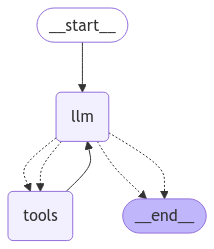

In [16]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


# Answers

In [17]:
# Qual é a composição do suplemento alimentar X?
# Quais são os efeitos do suplemento alimentar X? / O que faz o suplemento alimentar X?
# O que acontece se consumir X e tomar o suplemento alimentar Y?
# Como é o processo de toma do suplemento alimentar X?

quest_variants = load_variants_from_csv('variants.csv')

# Ingredientes
question1 = "Quais são os ingredientes do Condotril?"
question2 = "Quais são os ingredientes do Duobiotic?"
question3 = "Quais são os ingredientes do Neurofil?"

# Benefícios
question4 = "Quais são os benefícios do Condotril?"
question5 = "Quais são os benefícios do Duobiotic?"
question6 = "Quais são os benefícios do Neurofil?"

# Efeitos
question7 = "Quais são os efeitos do Condotril?"
question8 = "Quais são os efeitos do Duobiotic?"
question9 = "Quais são os efeitos do Nueurofil?"

# Processo de toma
question10 = "Qual é o processo de toma do Condotril?"
question11 = "Qual é o processo de toma do Duobiotic?"
question12 = "Qual é o processo de toma do Neurofil?"

# Condições de armazenamento
question13 = "Quais são as condições de armazenamento do Condotril?"
question14 = "Quais são as condições de armazenamento do Duobiotic?"
question15 = "Quais são as condições de armazenamento do Neurofil?"

# Precaussões
question16 = "Em que casos não se pode tomar Condotril?"
question17 = "Em que casos não se pode tomar Duobiotic?"
question18 = "Em que casos não se pode tomar Neurofil?"

In [ ]:
from langsmith import aevaluate
from langsmith.schemas import Run, Example
from langchain_ollama.llms import OllamaLLM

judge_llm = OllamaLLM(model="llama3.1:8b")

async def correct(outputs: dict, reference_outputs: dict) -> bool:
    instructions = (
        "Given an actual answer and an expected answer, determine whether"
        " the actual answer contains all of the information in the"
        " expected answer. Respond with 'CORRECT' if the actual answer"
        " does contain all of the expected information and 'INCORRECT'"
        " otherwise. Do not include anything else in your response."
    )
    # Our graph outputs a State dictionary, which in this case means
    # we'll have a 'messages' key and the final message should
    # be our actual answer.
    actual_answer = outputs["messages"][-1].content
    expected_answer = reference_outputs["answer"]
    user_msg = (
        f"ACTUAL ANSWER: {actual_answer}"
        f"\n\nEXPECTED ANSWER: {expected_answer}"
    )
    response = await judge_llm.ainvoke(
        [
            {"role": "system", "content": instructions},
            {"role": "user", "content": user_msg}
        ]
    )
    return response.content.upper() == "CORRECT"


def example_to_state(inputs: dict) -> dict:
  return {"messages": [{"role": "user", "content": "inputs['question']"}]}

# We use LCEL declarative syntax here.
# Remember that langgraph graphs are also langchain runnables.
target = example_to_state | graph

experiment_results = await aevaluate(
    target,
    data="evaluation_agent",
    evaluators=[correct],
    max_concurrency=4,  # optional
    experiment_prefix="claude-3.5-baseline",  # optional
)

def right_tool(outputs: dict) -> bool:
    tool_calls = outputs["messages"][1].tool_calls
    return bool(tool_calls and tool_calls[0]["name"] == "search")

experiment_results = await aevaluate(
    target,
    data="evaluation_agent",
    evaluators=[correct, right_tool],
    max_concurrency=4,  # optional
    experiment_prefix="claude-3.5-baseline",  # optional
)

def right_tool_from_run(run: Run, example: Example) -> dict:
    # Get documents and answer
    first_model_run = next(run for run in root_run.child_runs if run.name == "llm")
    tool_calls = first_model_run.outputs["messages"][-1].tool_calls
    right_tool = bool(tool_calls and tool_calls[0]["name"] == "search")
    return {"key": "right_tool", "value": right_tool}

experiment_results = await aevaluate(
    target,
    data="evaluation_agent",
    evaluators=[correct, right_tool_from_run],
    max_concurrency=4,  # optional
    experiment_prefix="claude-3.5-baseline",  # optional
)


node_target = example_to_state | graph.nodes["agent"]

node_experiment_results = await aevaluate(
    node_target,
    data="evaluation_agent",
    evaluators=[right_tool_from_run],
    max_concurrency=4,  # optional
    experiment_prefix="claude-3.5-model-node",  # optional
)

C:\Users\marta\AppData\Roaming\Python\Python312\site-packages\langsmith\client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


LangSmithAuthError: Authentication failed for /datasets. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/datasets?limit=1&name=evaluation_agent', '{"detail":"Invalid token"}')

In [203]:
user_question = "quais saõ os fundamnetso do condotirl?"
best_match, best_score = choose_best_question_variant(user_question, quest_variants)
refined_question = best_match if best_score >= 65 else user_question
response1 = graph.invoke({'messages': [system_prompt, HumanMessage(content=refined_question)]}, debug=True)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [SystemMessage(content='Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given context. \n  \nYour final answer should be as complete as possible. Do not oversimplify or summarize unnecessaraly, considering the results of the tools you used.\nDo not oversimplify or summarize the answer.\n\nIf you are unsure about what tool to use or how to correct an error, you should ask the user for help.', additional_kwargs={}, response_metadata={}, id='273adb07-2a5f-4a68-b5b5-02e4f1dbdec1'),
              HumanMessage(content='Quais sao os efeitos do Condotril', additional_kwargs={}, response_metadata={})]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [SystemMessage(content='Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given context.

In [ ]:
print("Pergunta: ", user_question)
print("Resposta completa: ", response1)
print("Resposta: ", response1['messages'][-1].content)

# save_question_answer(question1, response1['messages'][-1].content)

Pergunta:  Quais são os itens do Condotril?
Resposta completa:  {'messages': [SystemMessage(content='Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given context. \n  \nYour final answer should be as complete as possible. Do not oversimplify or summarize unnecessaraly, considering the results of the tools you used.\nDo not oversimplify or summarize the answer.\n\nIf you are unsure about what tool to use or how to correct an error, you should ask the user for help.', additional_kwargs={}, response_metadata={}, id='273adb07-2a5f-4a68-b5b5-02e4f1dbdec1'), HumanMessage(content='Quais são os itens do Condotril?', additional_kwargs={}, response_metadata={}, id='3302da12-a327-4c6a-a736-f6b60b433530'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1:8b', 'created_at': '2024-11-27T15:12:11.0647594Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'ArticleInformatio

In [ ]:
bonus_question = "Qual é a diferença entre Duobiotic e Neurofil?"
bonus_response = graph.invoke({'messages': [system_prompt, HumanMessage(content=bonus_question)]}, debug=True)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [SystemMessage(content='Your role is to act as a thorough research assistant, providing complete and detailed answers based on the given context. \n  \nYour final answer should be as complete as possible. Do not oversimplify or summarize unnecessaraly, considering the results of the tools you used.\nDo not oversimplify or summarize the answer.\n\nIf you are unsure about what tool to use or how to correct an error, you should ask the user for help.', additional_kwargs={}, response_metadata={}, id='0cb248fd-ca2c-4e89-b988-2151a35decce'),
              HumanMessage(content='Qual é a diferença entre Duobiotic e Neurofil?', additional_kwargs={}, response_metadata={})]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [SystemMessage(content='Your role is to act as a thorough research assistant, providing complete and detailed answers based on the g

In [ ]:
print("Pergunta:", bonus_question)
print("Resposta:\n", bonus_response['messages'][-1].content)

# save_question_answer(bonus_question, bonus_response['messages'][-1].content)

Pergunta: Qual é a diferença entre Duobiotic e Neurofil?
Resposta:
 O Duobiotic é um suplemento alimentar que contém lactobacilos e bifidobactérias, enriquecido com açúcares não digeríveis e vitaminas. Já o Neurofil parece ser uma substância relacionada ao sistema nervoso, mas não há informações suficientes para compará-los diretamente.

No entanto, é importante notar que o Duobiotic é um suplemento alimentar destinado a complementar e/ou a suplementar o regime alimentar normal, enquanto o Neurofil parece ser uma substância relacionada ao sistema nervoso. Portanto, eles têm objetivos e funções diferentes.

Se você está procurando por informações sobre o Duobiotic ou o Neurofil, recomendo consultar um profissional de saúde ou realizar pesquisas adicionais para obter mais informações precisas.


### Comparar a respostas obtidas à resposta correta (fine-tunning?)

In [4]:
df_generated = load_dataframe('questions_answers.csv')
df_generated

,question,answer
0,Quais sao os ingredientes do Condotril,Os ingredientes do Condotril são:\n\n- Agente ...
1,Qual é a diferença entre Duobiotic e Neurofil?,O Duobiotic é um suplemento alimentar que cont...


In [5]:
df_correct = load_dataframe('answers.csv')
df_correct

,Questions,Answers
0,Quais sao os ingredientes do Condotril?,Os ingredientes do Condotril incluem: agentes ...
1,Quais sao os ingredientes do Duobiotic?,Os ingredientes do Duobiotic incluem: Fruto-ol...
2,Quais sao os ingredientes do Neurofil?,Os ingredientes do Neurofil incluem:\r\nÓleo d...
3,Quais sao os efeitos do Condotril?,Os efeitos do Condotril incluem melhorias na s...
4,Quais sao os efeitos do Duobiotic?,Os efeitos do Duobiotic incluem melhorias na s...
5,Quais sao os efeitos do Neurofil?,Os efeitos do Neurofil incluem a melhoria da f...
6,Qual e o processo de toma do Condotril?,O Duobiotic deve ser tomado 1 saqueta dia. Dis...
7,Qual e o processo de toma do Duobiotic?,O Duobiotic deve ser tomado 1 saqueta dia. Di...
8,Qual e o processo de toma do Neurofil?,O Neurofil deve ser tomado 1 a 2 cápsulas por ...
9,Quais sao as condicoes de armazenamento do Con...,Conservar em local seco na embalagem original ...


In [54]:
from langsmith import Client
import pandas as pd
import os

# Set environment variables for LangSmith API
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "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"

# Carregar o arquivo CSV
df_correct = pd.read_csv('answers.csv')  # Certifique-se de que o arquivo tenha os headers 'Questions' e 'Answers'

# Instanciar o cliente LangSmith
ls_client = Client(api_key="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")

# Listar datasets existentes
datasets = ls_client.list_datasets()
for dataset in datasets:
    ls_client.delete_dataset(dataset_id=dataset.id)  # Delete the dataset using the ID
    print(f"Dataset {dataset.name} deleted.")

# Verificar se o dataset "evaluation_agent" já existe
datasets = ls_client.list_datasets()
dataset_exists = any(dataset.name == "evaluation_agent" for dataset in datasets)

if not dataset_exists:
    # Criar o dataset se ele não existir
    dataset = ls_client.create_dataset("evaluation_agent")
    print(f"Dataset '{dataset.name}' created successfully.")
else:
    print("Dataset 'evaluation_agent' already exists.")

# Extrair perguntas e respostas
questions = df_correct['Questions'].tolist()
answers = df_correct['Answers'].tolist()

# Verificar se as colunas necessárias existem
if 'Questions' not in df_correct.columns or 'Answers' not in df_correct.columns:
    raise ValueError("O arquivo CSV deve conter as colunas 'Questions' e 'Answers'.")

# Agora, vamos criar os exemplos no dataset
try:
    # Adicionar exemplos ao dataset
    ls_client.create_examples(
        inputs=[{"question": q} for q in questions],  # A chave de entrada deve ser 'question' ou conforme a especificação do seu dataset
        outputs=[{"answer": a} for a in answers],  # A chave de saída deve ser 'answer' ou conforme a especificação do seu dataset
        dataset_id=dataset.id,  # ID do dataset
    )
    print(f"Exemplos adicionados ao dataset '{dataset.name}' com sucesso.")
except Exception as e:
    print(f"Erro ao adicionar exemplos ao dataset: {e}")


Dataset evaluation_agent deleted.
Dataset 'evaluation_agent' created successfully.
Exemplos adicionados ao dataset 'evaluation_agent' com sucesso.


In [15]:
def compare_answers(df_generated, df_correct, question1, best_match, idx1, idx2):
    # Obter as respostas associadas
    generated_answer = df_generated.loc[idx1, 'answer']
    correct_answer = df_correct.loc[idx2, 'Answers']

    # Calcular similaridade entre respostas
    answer_score = fuzz.ratio(generated_answer.lower(), correct_answer.lower())

    # Exibir os resultados
    print("=" * 50)
    print(f"\n\nPergunta Gerada: {question1}")
    print(f"Resposta Gerada: {generated_answer}")
    print(f"Melhor Pergunta Similar: {best_match}")
    print(f"Resposta Correta: {correct_answer}")
    print(f"Similaridade entre Respostas: {answer_score}")
    print("=" * 50)

def evaluate_answers(df_generated, df_correct):
    for idx1, question1 in enumerate(df_generated['question']):
        best_match = None
        best_score = 0
        best_idx2 = None

        # print(f"Pergunta Gerada ({idx1}): {question1}")
        for idx2, question2 in enumerate(df_correct['Questions']):
            score = fuzz.ratio(question1.lower(), question2.lower())

            if score > best_score:
                best_score = score
                best_match = question2
                best_idx2 = idx2  # Índice da melhor correspondência

        # Chamar compare_answers se a pontuação for suficiente
        if best_score > 65:
            compare_answers(df_generated, df_correct, question1, best_match, idx1, best_idx2)

In [70]:
evaluate_answers(df_generated, df_correct)



Pergunta Gerada: Quais sao os ingredientes do Condotril
Resposta Gerada: Os ingredientes do Condotril são:

- Agente de volume: Maltodextrina
- Sulfato de glucosamina (marinho)
- Sulfato de condroitina
- Agente de volume: Fosfato dicálico
- Cartilagem de tubarão
- Aroma de laranja
- Metilsulfonilmetano (MSM)
- Extrato seco de Bambusa vulgaris (Bambu), exsudado do caule, doseado a 75% de Sílica
- Extrato seco de Harpagophytum procumbens (Harpago), raiz, doseado a 2% de Harpágidos
- Acidificante: Ácido cítrico
- Colageno hidrolisado tipo I
- Vitamina C (Ácido t-ascorbico)
- Antiaglomerante: Dióxido de silício
- Gluconmato de manganês (Manganês)
- Hialuronato de sódio (Ácido hialurônico)
- Edulcorante: Sucralose

Além disso, o Condotril também contém os seguintes ingredientes em quantidades diárias:

- Sulfato de Glucosamina: 750 mg
- Sulfato de Condroitina: 300 mg
- Cartilagem de tubarão: 150 mg
- Metilsulfonilmetano (MSM): 120 mg
- Sílica: 90 mg
- Extrato seco de Harpagophytum procumb

In [ ]:
# falta adaptar a função 'compare_questions' para que calcule a acuracy entre a resposta gerada (do dataframe 'df_generated')
# e a resposta correta (do dataframe 'df_correct')
# VER MELHOR O CODIGO ABAIXO (foi o chat que fez)

# O CENAS DE BAIXO É IMPORTANTE PARA O "FINE TUNNING"

In [ ]:
def compare_answers(question, generated_answer, df_correct):
    best_match = None
    best_score = 0
    best_correct_answer = None

    # Encontrar a melhor correspondência para a pergunta
    for idx, ref_question in enumerate(df_correct['Questions']):
        score = fuzz.ratio(question.lower(), ref_question.lower())
        if score > best_score:
            best_score = score
            best_match = ref_question
            best_correct_answer = df_correct.loc[idx, 'Answers']

    # Calcular similaridade entre as respostas
    if best_match:
        answer_score = fuzz.ratio(generated_answer.lower(), best_correct_answer.lower())
        print(f"Pergunta Gerada: {question}")
        print(f"Resposta Gerada: {generated_answer}")
        print(f"Melhor Correspondência: {best_match} (score={best_score})")
        print(f"Resposta Correta: {best_correct_answer}")
        print(f"Similaridade da Resposta: {answer_score}")
        print("=" * 50)
        return best_score, answer_score
    else:
        print(f"Nenhuma correspondência encontrada para a pergunta: {question}")
        return 0, 0